In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter code_exec

{% do SectionField(
    name='Datasets',
    title='Coding/Noncoding Gene Selection',
    img='TCGA.png'
)%}

gene = {{ AutocompleteField(
    name='gene_input',
    file_path="https://appyters.maayanlab.cloud/storage/ncRNA_predictions/TCGA.json",
    label='autocomplete',
    title='Search Gene Symbol:',
    description='Select a gene among 38,550 genes found in TCGA',
    section='Datasets',
    default='TSPAN6'
)}}

```python

gene = 'TSPAN6'
```

In [3]:
import h5py
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
from scipy.stats import zscore
import urllib.request
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
from IPython.display import clear_output, display_html, HTML 
import requests
import os
from maayanlab_bioinformatics.harmonization import ncbi_genes
import s3fs
import base64
import json

# Fetch and load data

Fetch and load prepared TCGA correlation matrix into a DataFrame - 38550 coding and noncoding genes

In [4]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://appyters.maayanlab.cloud/storage'})

In [9]:
with s3.open("ncRNA_predictions/tcga_cor.h5") as s3f:
    with h5py.File(s3f, 'r') as f: 
        tcga_genes = np.transpose([str(g[0])[2:-1] for g in f['tcga_genes']])
        gene_idx = np.where(tcga_genes == gene)[0][0]
        tcga_cor = pd.DataFrame(f['corr_matrix'][gene_idx], index=tcga_genes, columns=[gene])

SyntaxError: unexpected EOF while parsing (<ipython-input-9-097f5610d96f>, line 5)

Fetch and load prepared ARCHS4 human correlation matrix into a DataFrame - 26415 coding genes

In [167]:
with s3.open("ncRNA_predictions/human_correlation.h5") as s3f:
    with h5py.File(s3f, 'r') as f:
        archs4_genes = np.transpose([str(g[0])[2:-1] for g in f['genes']])
        if gene in set(archs4_genes):
            gene_idx = np.where(archs4_genes == gene)[0][0]
            filtered_genes = [str(g[0])[2:-1] for g in f['filtered_genes']] # only genes found in gene set libraries
            archs4_cor = pd.DataFrame(f['human_correlation'][gene_idx], index=filtered_genes, columns=[gene])
            archs4_cor.loc[gene] = 0
        else: archs4_cor = pd.DataFrame()

Fetch reference prediction matrices prepared from Enrichr [gene set libraries](https://amp.pharm.mssm.edu/Enrichr/#stats).

In [1]:
libraries = ['GO_Biological_Process_2018', 'ChEA_2016', 'MGI_Mammalian_Phenotype_Level_4_2019', 'KEGG_2019_Human',
              'KEA_2015', 'Human_Phenotype_Ontology', 'WikiPathways_2019_Human']

In [4]:
gene_set_libraries = {}
with s3.open("ncRNA_predictions/gene_set_libraries") as s3f:
    with h5py.File(s3f, 'r') as f:
        for idx in trange(len(libraries)):
            library = libraries[idx]
            if library in list(f.keys()):
                gene_set_libraries[library] = np.array(f[library]['gslib'])

NameError: name 's3' is not defined

Fetch NCBI data to determine gene types.

In [ ]:
ncbi = pd.DataFrame(ncbi_genes.ncbi_genes_fetch())
all_symbols = ncbi.Symbol.values
ncbi = ncbi[["type_of_gene"]]
ncbi["Symbol"] = all_symbols
ncbi = ncbi.set_index("Symbol")
symbol_to_gene_type = ncbi.to_dict()["type_of_gene"]

# Predicting the top correlated functions and genes

In this section, we define a pipeline with functions that will determine the top functions correlated to the user-inputted gene for each Enrichr library, and the top correlated genes, for both TCGA and ARCHS4.

Given a gene set library's name, pull the library from Enrichr and return a dictionary with functions as keys and genes as values and a sorted set of the gene set library's genes.

In [68]:
def gene_set_dictionaries(library):
    print("Creating dictionary from %s." % library)
    enrichr_url = 'https://amp.pharm.mssm.edu/Enrichr/geneSetLibrary?mode=text&libraryName='
    data = urllib.request.urlopen(enrichr_url + library)
    function_to_genes = {}
    gene_set = set() 
    for line in data:
        lst = (str(line.strip())[2:-1]).split(r'\t')
        function = lst[0]
        genes = lst[2:]
        function_to_genes[function] = genes
        gene_set.update(set(genes))
    clear_output()
    print("Completed creating dictionary from %s." % library)
    return function_to_genes, sorted(gene_set)

Given the function-to-gene dictionary and set of genes from the above function, create a binary matrix with genes as rows and functions as columns (value of 1 means the gene is associated with the given function).

In [69]:
def gs_binary_matrix(function_to_genes, gene_set):
    print("Creating binary matrix.")
    binary_matrix = np.zeros((len(gene_set), len(function_to_genes)))
    binary_matrix = pd.DataFrame(data=binary_matrix, index=gene_set, columns=list(function_to_genes.keys()))
    for function in binary_matrix.columns: 
        gene_list = function_to_genes[function]
        binary_matrix.loc[gene_list, function] += 1
    clear_output()
    print("Completed creating binary matrix.")
    return binary_matrix

Given the library name as well as the function-to-gene dictionary and gene set from above, load the gene set prediction matrix as a DataFrame with genes as rows, functions as columns. In this prediction matrix, in each (gene, gene set/function) cell is the correlation of that gene for a given gene set (function) to every other gene in that gene set.

In [198]:
def gene_set_library(library, function_to_genes, gene_set):
    clear_output()
    gslib = pd.DataFrame(gene_set_libraries[library], index=gene_set, columns=function_to_genes.keys())
    return gslib

In [2]:
def new_gene_set_library(binary_matrix, function_to_genes):
    cor = pd.DataFrame(np.corrcoef(binary_matrix), index=binary_matrix.index, columns=binary_matrix.index)
    gslib = np.zeros((len(binary_matrix.index)))
    gslib = pd.DataFrame(data=gslib, index=list(binary_matrix.index))
    preds = []
    for function in function_to_genes:
        genes = function_to_genes[function]
        preds.append(cor.loc[:, genes].mean(axis=1))
    gslib = pd.concat(preds, axis=1)
    gslib.columns = list(function_to_genes.keys())
    return gslib

Generate a new prediction matrix combining the gene set prediction matrix above and the TCGA or ARCHS4 correlation matrix. The following formula is used to make predictions about the chosen gene using the TCGA or ARCHS4 correlation matrix.

<div style=margin-top:20px> 
    <img src="static/geneshot_formula.png" width="50%" height="50%" style='border:0.1px solid light gray' />
    <div style=text-align:center;margin-top:20px> 
        Fig. 1: Formula found in the <a href='https://academic.oup.com/nar/article/47/W1/W571/5494749'>Geneshot paper</a> to calculate the prediction matrix. G is the correlation matrix, GF is the gene set prediction matrix, and GF' is the new prediction matrix to make predictions about the given dataset. Note: the denominator should be GF instead of G.
    </div>
</div>

In [200]:
def prediction_matrix(gene, cor_matrix, gslib):
    idx = [ g for g in gslib.index if g in cor_matrix.index ]
    smaller_cor = cor_matrix.loc[idx] 
    smaller_gslib = gslib.loc[idx]
    pred_matrix = np.dot(np.transpose(smaller_cor), smaller_gslib)
    if gene in smaller_gslib.index: gslib = gslib.drop(index=gene)
    function_sums = np.array(np.sum(gslib))
    pred_matrix /= function_sums
    return pd.DataFrame(data=np.transpose(pred_matrix), index=gslib.columns, columns=[gene])

Return the top 50 most correlated functions and 100 most correlated genes associated with the given gene.

In [201]:
def top_ranked(matrix, gene): 
    top = matrix.sort_values(ascending=False)
    z_scores = pd.DataFrame(zscore(top), index=top.index)
    genes = pd.DataFrame(list(top.index), index=top.index) 
    top = pd.concat([genes, top, z_scores], axis=1)
    top.index = list(range(1, len(top)+1))
    return top

In [202]:
def get_top_functions(matrix, gene, name):
    top = top_ranked(matrix.loc[:,gene], gene).head(50)
    top.columns = ["%s - Annotation" % name, "%s - Score" % name, "%s - Z-Score" % name]
    return top

In [203]:
def get_top_genes(matrix, gene, name):
    top = top_ranked(matrix.T.loc[gene], gene)
    top.columns = ["%s - Symbol" % name, "%s - Score" % name, "%s - Z-Score" % name] 
    def id_to_type(key):
        if (key in symbol_to_gene_type):
            return symbol_to_gene_type[key]
        else:
            return None
    gene_types = np.transpose([ id_to_type(key) for key in top.loc[:, '%s - Symbol' % name ]])
    top.insert(1, "%s - Annotation" % name, gene_types)
    top_ncRNA = None
    if name == "TCGA": 
        top_ncRNA = top.loc[top['%s - Annotation' % name] == ('ncRNA' or 'rRNA' or 'snoRNA' or 'snRNA' or 'siRNA')].head(100)
    return top.head(100), top_ncRNA

Graph the AUROC for the TCGA and ARCHS4 predictions.

In [10]:
def auc(binary_matrix, tcga_probs, archs4_probs, gene):
    if gene not in binary_matrix.index: 
        print("Not enough gene annotations available.")
        return
    tcga_probs = tcga_probs.fillna(tcga_probs.mean())
    if not archs4_probs.empty: archs4_probs = archs4_probs.fillna(archs4_probs.mean())
    y_true = binary_matrix.loc[gene]
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, _ = roc_curve(y_true, tcga_probs)
    apr, bpr, _ = roc_curve(y_true, archs4_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    tcga_auc = roc_auc_score(y_true, tcga_probs)
    archs4_auc = roc_auc_score(y_true, archs4_probs)
    pyplot.figure(figsize=(11,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("TCGA: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % tcga_auc, fontsize=12)
    
    pyplot.subplot(1,2,2)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(apr, bpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ARCHS4: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % archs4_auc, fontsize=12)
    pyplot.tight_layout()
    pyplot.show()

Process to determine top correlated functions using the above functions, display DataFrames alongside each other to facilitate comparison and a download link for the data.

In [234]:
def functional_comparison(current_lib):
    function_to_genes, gene_set = gene_set_dictionaries(current_lib)
    binary_matrix = gs_binary_matrix(function_to_genes, gene_set)
    if current_lib in gene_set_libraries: gslib = gene_set_library(current_lib, function_to_genes, gene_set)
    else: gslib = new_gene_set_library(binary_matrix, function_to_genes)
    tcga_pred_matrix = prediction_matrix(gene, tcga_cor, gslib)
    clear_output()
    print("Completed creating TCGA prediction matrix.")
    top_tcga_functions = get_top_functions(tcga_pred_matrix, gene, "TCGA")
    if not archs4_cor.empty:
        archs4_pred_matrix = prediction_matrix(gene, archs4_cor, gslib)
        clear_output()
        print("Completed creating ARCHS4 prediction matrix.")
        top_archs4_functions = get_top_functions(archs4_pred_matrix, gene, "ARCHS4")
        combined_df = pd.concat([top_tcga_functions, top_archs4_functions], axis=1)
    else:
        archs4_pred_matrix = pd.DataFrame()
        combined_df = top_tcga_functions
    clear_output()
    display(download_link(combined_df, "Download top 50 predicted functions from %s" % current_lib, "T50_functions_%s.csv" % current_lib)) 
    display_df(combined_df.head(10))
    return binary_matrix, tcga_pred_matrix, archs4_pred_matrix

In [229]:
def display_df(df):
#     symbol_indices = [i for i in df.columns if i.split(" - ")[-1] == "Symbol"]
#     if symbol_indices: n = df.style.set_table_attributes("style='max-width:95%;margin:auto'").format(get_enrichr_link, subset=symbol_indices)
    n = df.style.set_table_attributes("style='max-width:95%;margin:auto'")
    display_html(n._repr_html_(), raw=True)

In [232]:
def download_link(content, title, filename):  
    csv = content.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
def predictions():
    for library in libraries: 
        display(HTML('<h1> %s </h1>' % " ".join(library.split("_"))))
        display(HTML('<div> Side-by-side comparison of the top </div>'))

In [17]:
def get_enrichr_link(genes, name):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
    genes_str = '\n'.join(genes)
    payload = {'list': (None, genes_str)}
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    dataset = json.loads(response.text)['shortId']
    url = 'https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=' + dataset 
    html = '<a href="%s">Learn more about the top 100 correlated %s genes in Enrichr</a>' % (url, name)
    display(HTML(html))

# Predicted pathways (GO)

Side-by-side comparison of the top predicted pathways.

In [235]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[0])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,tryptophan catabolic process (GO:0006569),3.143288,16.064300,tryptophan catabolic process (GO:0006569),0.254708,2.385165
2,indolalkylamine catabolic process (GO:0046218),1.288079,6.535628,ubiquinone metabolic process (GO:0006743),0.252402,2.364202
3,succinyl-CoA metabolic process (GO:0006104),1.000186,5.056960,quinone biosynthetic process (GO:1901663),0.252402,2.364202
4,flavonoid glucuronidation (GO:0052696),0.822875,4.146261,protein C-linked glycosylation via tryptophan (GO:0018317),0.220329,2.072686
5,ethanol catabolic process (GO:0006068),0.738542,3.713111,protein C-linked glycosylation via 2'-alpha-mannosyl-L-tryptophan (GO:0018406),0.220329,2.072686
6,ethanol metabolic process (GO:0006067),0.738542,3.713111,ketone body metabolic process (GO:1902224),0.190788,1.804189
7,glucuronate metabolic process (GO:0019585),0.698396,3.506916,flavonoid glucuronidation (GO:0052696),0.171408,1.628042
8,xenobiotic glucuronidation (GO:0052697),0.691710,3.472576,nucleotide phosphorylation (GO:0046939),0.162075,1.543212
9,ketone body metabolic process (GO:1902224),0.675301,3.388297,succinyl-CoA metabolic process (GO:0006104),0.154472,1.474108
10,cellular glucuronidation (GO:0052695),0.670866,3.365518,ketone body biosynthetic process (GO:0046951),0.142340,1.363839


AUROC for the TCGA and ARCHS4-generated predictions.

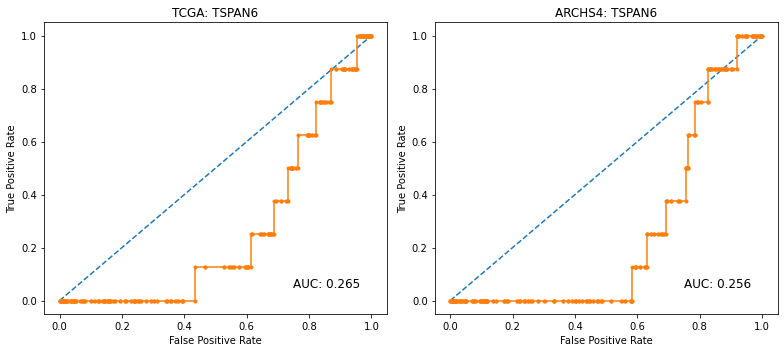

In [236]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

# Predicted upstream transcription factors (ChEA)

Side-by-side comparison of the top predicted upstream transcription factors.

In [237]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[1])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,TRIM28 17542650 ChIP-ChIP NTERA2 Human,0.157950,6.705809,TRIM28 17542650 ChIP-ChIP NTERA2 Human,0.023215,6.718564
2,EED 16625203 ChIP-ChIP MESCs Mouse,0.125763,4.955515,FLI1 27457419 Chip-Seq LIVER Mouse,0.010249,3.112706
3,SUZ12 16625203 ChIP-ChIP MESCs Mouse,0.113410,4.283785,PCGF2 27294783 Chip-Seq ESCs Mouse,0.009414,2.880416
4,SUZ12 18555785 ChIP-Seq MESCs Mouse,0.108960,4.041763,RBPJ 22232070 ChIP-Seq NCS Mouse,0.008814,2.713679
5,PHC1 16625203 ChIP-ChIP MESCs Mouse,0.108238,4.002502,GLI1 17442700 ChIP-ChIP MESCs Mouse,0.008359,2.586985
6,EZH2 18974828 ChIP-Seq MESCs Mouse,0.107585,3.967035,EST1 17652178 ChIP-ChIP JURKAT Human,0.007890,2.456547
7,RNF2 18974828 ChIP-Seq MESCs Mouse,0.107585,3.967035,VDR 22108803 ChIP-Seq LS180 Human,0.007887,2.455923
8,JARID2 20064375 ChIP-Seq MESCs Mouse,0.104605,3.804980,ZFP57 27257070 Chip-Seq ESCs Mouse,0.007751,2.417971
9,SUZ12 18692474 ChIP-Seq MESCs Mouse,0.104572,3.803165,CREB1 15753290 ChIP-ChIP HEK293T Human,0.007701,2.404040
10,EZH2 27304074 Chip-Seq ESCs Mouse,0.104441,3.796058,SUZ12 27294783 Chip-Seq NPCs Mouse,0.007531,2.356844


AUROC for the TCGA and ARCHS4-generated predictions.

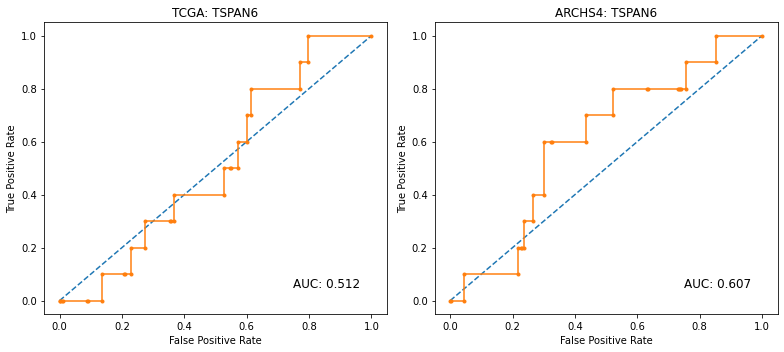

In [238]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

# Predicted mouse phenotypes (MGI)

Side-by-side comparison of the top predicted mouse phenotypes.

In [239]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[2])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,MP:0004525 thin cochlear hair cell stereocilia,0.119713,3.172875,MP:0005411 delayed fertilization,0.026390,2.946507
2,MP:0004292 abnormal spiral ligament fibrocyte morphology,0.095269,2.210572,MP:0013987 absent intrahepatic inferior vena cava segment,0.025918,2.900348
3,MP:0004287 abnormal spiral limbus morphology,0.090619,2.027515,MP:0020451 decreased sperm progressive motility,0.024690,2.780450
4,MP:0000044 absent organ of Corti,0.088201,1.932313,MP:0013858 abnormal azygos vein topology,0.024398,2.751976
5,MP:0006083 abnormal blood vessel elastic tissue morphology,0.087886,1.919937,MP:0030590 abnormal sperm fibrous sheath morphology,0.023608,2.674783
6,MP:0004397 absent cochlear inner hair cells,0.085818,1.838518,MP:0008878 abnormal DNA methylation during gametogenesis,0.023268,2.641568
7,MP:0010570 prolonged ST segment,0.085344,1.819848,MP:0009830 abnormal sperm connecting piece morphology,0.023143,2.629361
8,MP:0004414 decreased cochlear microphonics,0.084985,1.805726,MP:0008581 disorganized photoreceptor inner segment,0.022363,2.553173
9,MP:0005199 abnormal iris pigment epithelium,0.083528,1.748369,MP:0009833 absent sperm mitochondrial sheath,0.022241,2.541234
10,MP:0009742 increased corneal stroma thickness,0.082380,1.703169,MP:0013996 abnormal vertebral artery origin,0.022077,2.525297


AUROC for the TCGA and ARCHS4-generated predictions.

In [240]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

Not enough gene annotations available.


# Predicted pathways (KEGG)

Side-by-side comparison of the top predicted pathways.

In [241]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[3])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,Metabolism of xenobiotics by cytochrome P450,2.846349,8.392704,Metabolism of xenobiotics by cytochrome P450,0.685643,6.369033
2,Chemical carcinogenesis,2.296048,6.772142,Sphingolipid metabolism,0.660177,6.145228
3,Homologous recombination,1.691247,4.991085,Aminoacyl-tRNA biosynthesis,0.568293,5.337715
4,PPAR signaling pathway,1.378695,4.070662,Chemical carcinogenesis,0.540770,5.095824
5,Nucleotide excision repair,0.825336,2.441093,Fanconi anemia pathway,0.333315,3.272617
6,Drug metabolism,0.767660,2.271247,Proteasome,0.303337,3.009161
7,Lysine degradation,0.704284,2.084612,Drug metabolism,0.225705,2.326892
8,Peroxisome,0.680142,2.013517,PPAR signaling pathway,0.194712,2.054518
9,Sphingolipid metabolism,0.608517,1.802593,Peroxisome,0.153462,1.691990
10,Bile secretion,0.506304,1.501588,SNARE interactions in vesicular transport,0.147120,1.636253


AUROC for the TCGA and ARCHS4-generated predictions.

In [242]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

Not enough gene annotations available.


# Predicted kinase interactions (KEA)

Side-by-side comparison of the top predicted kinase interactions.

In [243]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[4])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,CASK,0.276514,nan,PIK3CG,0.083095,nan
2,PINK1,0.105027,nan,NEK2,0.026802,nan
3,EPHA4,0.092881,nan,STK39,0.024171,nan
4,EPHB2,0.076415,nan,TAOK3,0.016422,nan
5,KDR,0.058328,nan,IRAK2,0.004613,nan
6,TESK2,0.054491,nan,NEK9,-0.000427,nan
7,PDK4,0.049440,nan,TNIK,-0.002034,nan
8,PDK3,0.049440,nan,MUSK,-0.002116,nan
9,CAMKK2,0.047395,nan,SRPK1,-0.004410,nan
10,MST4,0.043668,nan,PNCK,-0.006438,nan


AUROC for the TCGA and ARCHS4-generated predictions.

In [244]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

Not enough gene annotations available.


# Predicted human phenotypes

Side-by-side comparison of the top predicted human phenotypes.

In [245]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[5])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,Acute necrotizing encephalopathy (HP:0006965),0.073790,2.659172,True hermaphroditism (HP:0010459),0.017165,3.154679
2,Abnormal mitochondria in muscle tissue (HP:0008316),0.072704,2.517507,Pancreatic fibrosis (HP:0100732),0.017096,3.140168
3,Acute encephalopathy (HP:0006846),0.070934,2.286471,Gait imbalance (HP:0002141),0.016354,2.985742
4,Progressive macrocephaly (HP:0004481),0.070743,2.261487,Medial flaring of the eyebrow (HP:0010747),0.016270,2.968245
5,Supraventricular tachycardia (HP:0004755),0.070301,2.203823,Molar tooth sign on MRI (HP:0002419),0.015526,2.813397
6,Primary atrial arrhythmia (HP:0001692),0.070208,2.191644,Abnormality of midbrain morphology (HP:0002418),0.015526,2.813397
7,Cerebral edema (HP:0002181),0.070147,2.183752,Congenital primary aphakia (HP:0007707),0.015290,2.764209
8,Supraventricular arrhythmia (HP:0005115),0.070097,2.177204,Pancreatic cysts (HP:0001737),0.015035,2.711143
9,Atrial fibrillation (HP:0005110),0.069907,2.152467,Poor coordination (HP:0002370),0.014669,2.634993
10,X-linked dominant inheritance (HP:0001423),0.068577,1.978843,Nephrogenic diabetes insipidus (HP:0009806),0.014466,2.592765


AUROC for the TCGA and ARCHS4-generated predictions.

In [246]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

Not enough gene annotations available.


# Predicted Biological Pathways (WikiPathways)

Side-by-side comparison of the top predicted biological pathways from WikiPathways.

In [245]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[-1])

,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,Acute necrotizing encephalopathy (HP:0006965),0.073790,2.659172,True hermaphroditism (HP:0010459),0.017165,3.154679
2,Abnormal mitochondria in muscle tissue (HP:0008316),0.072704,2.517507,Pancreatic fibrosis (HP:0100732),0.017096,3.140168
3,Acute encephalopathy (HP:0006846),0.070934,2.286471,Gait imbalance (HP:0002141),0.016354,2.985742
4,Progressive macrocephaly (HP:0004481),0.070743,2.261487,Medial flaring of the eyebrow (HP:0010747),0.016270,2.968245
5,Supraventricular tachycardia (HP:0004755),0.070301,2.203823,Molar tooth sign on MRI (HP:0002419),0.015526,2.813397
6,Primary atrial arrhythmia (HP:0001692),0.070208,2.191644,Abnormality of midbrain morphology (HP:0002418),0.015526,2.813397
7,Cerebral edema (HP:0002181),0.070147,2.183752,Congenital primary aphakia (HP:0007707),0.015290,2.764209
8,Supraventricular arrhythmia (HP:0005115),0.070097,2.177204,Pancreatic cysts (HP:0001737),0.015035,2.711143
9,Atrial fibrillation (HP:0005110),0.069907,2.152467,Poor coordination (HP:0002370),0.014669,2.634993
10,X-linked dominant inheritance (HP:0001423),0.068577,1.978843,Nephrogenic diabetes insipidus (HP:0009806),0.014466,2.592765


AUROC for the TCGA and ARCHS4-generated predictions.

In [246]:
auc(binary_matrix, tcga_pred_matrix, archs4_pred_matrix, gene)

Not enough gene annotations available.


# Top coding and non-coding genes
Side-by-side comparison of the top correlated genes.

The top 100 most correlated genes.

In [251]:
top_tcga_genes, top_ncRNA = get_top_genes(tcga_cor, gene, "TCGA")
top_archs4_genes, _ = get_top_genes(archs4_cor, gene, "ARCHS4")
combined_genes = pd.concat([top_tcga_genes, top_archs4_genes], axis=1)
display(download_link(combined_genes, "Download top 100 most correlated genes", "most_correlated_genes.csv"))
get_enrichr_link(combined_genes['TCGA - Symbol'], 'TCGA')
get_enrichr_link(combined_genes['ARCHS4 - Symbol'], 'ARCHS4')
display_df(combined_genes)

,TCGA - Symbol,TCGA - Annotation,TCGA - Score,TCGA - Z-Score,ARCHS4 - Symbol,ARCHS4 - Annotation,ARCHS4 - Score,ARCHS4 - Z-Score
1,YAP1,protein-coding,0.775847,3.131886,TSPAN6,protein-coding,1.000000,14.043683
2,NCKAP1,protein-coding,0.766423,3.092375,SRP9,protein-coding,0.336631,4.698798
3,BCAR1,protein-coding,0.755142,3.045084,LDHB,protein-coding,0.305569,4.261222
4,TJP1,protein-coding,0.753136,3.036673,TMEM98,protein-coding,0.300561,4.190676
5,PARVA,protein-coding,0.746008,3.006790,PTBP2,protein-coding,0.290600,4.050355
6,CNN3,protein-coding,0.740512,2.983750,CNN3,protein-coding,0.286767,3.996363
7,SNX7,protein-coding,0.733892,2.956001,SUMO2,protein-coding,0.284384,3.962795
8,PPIC,protein-coding,0.725782,2.922001,HMGN3,protein-coding,0.279921,3.899919
9,GNG12,protein-coding,0.724730,2.917589,H2AFZ,None,0.278830,3.884563
10,TMEM98,protein-coding,0.718019,2.889456,OSTC,protein-coding,0.272566,3.796320


The gene types of the top 100 most correlated genes.

In [248]:
filtered_tcga_types = np.transpose(list(combined_genes['TCGA - Annotation']))
filtered_tcga_types = filtered_tcga_types[filtered_tcga_types!=None]
filtered_archs4_types = np.transpose(list(combined_genes['ARCHS4 - Annotation']))
filtered_archs4_types = filtered_archs4_types[filtered_archs4_types!=None]
tcga_counts = np.unique(filtered_tcga_types, return_counts=True)
archs4_counts = np.unique(filtered_archs4_types, return_counts=True)
rows = list( set(tcga_counts[0]) | set(archs4_counts[0]) )
gene_types = pd.DataFrame(0, index = rows, columns=["TCGA", "ARCHS4"])
gene_types.loc[tcga_counts[0], "TCGA"] = tcga_counts[1]
gene_types.loc[archs4_counts[0], "ARCHS4"] = archs4_counts[1]
if "unknown" in gene_types.columns: gene_types.loc["unknown"] += [100 - sum(tcga_counts[1]), 100 - sum(archs4_counts[1])]
else: gene_types.loc["unknown"] = [100 - sum(tcga_counts[1]), 100 - sum(archs4_counts[1])]
display_df(gene_types)

,TCGA,ARCHS4
protein-coding,100,96
unknown,0,4


The top 100 most correlated noncoding genes. 

In [254]:
display(download_link(top_ncRNA, "Download top 100 ncRNA", "top_100_ncRNA.csv"))
get_enrichr_link(top_ncRNA['TCGA - Symbol'], 'ncRNA')
display_df(top_ncRNA)

,TCGA - Symbol,TCGA - Annotation,TCGA - Score,TCGA - Z-Score
399,LOC257396,ncRNA,0.509302,2.014458
476,TMEM99,ncRNA,0.490020,1.933624
578,HAGLR,ncRNA,0.469260,1.846592
741,LINC00473,ncRNA,0.437548,1.713651
893,RASAL2-AS1,ncRNA,0.416832,1.626803
895,WDFY3-AS2,ncRNA,0.416735,1.626397
927,MIG7,ncRNA,0.412584,1.608993
965,LOC730101,ncRNA,0.406812,1.584798
1012,LINC00673,ncRNA,0.400124,1.556759
1162,H19,ncRNA,0.381876,1.480257
